In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
#!{sys.executable} -m pip install pandas-profiling

Reading in the compressed data

In [2]:
dat = pd.read_csv('../dat/online_shoppers_intention.csv.gz', compression='gzip')

Lets explore the data, what do the records look like?

In [3]:
dat.info() #12,330 and 18 columns
dat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Saving a report on the summary stats of each variable, the correlations in output.html file

In [4]:
from pandas_profiling import ProfileReport
prof = ProfileReport(dat)
#prof.to_notebook_iframe()
prof.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#Here is what we know so far about our data:

1) of the 12,330 rows, 0.6% of data are duplicates - lets delete?
2) 14 numerical and 2 categorical and 2 boolean -- changing few columns to categorical in next step
3) Features Administrative, Administrative_duration, Informational,Informational_duration, bounce rates, pagevalues and SpecialDay have predominant portion of zeroes
4) Dependent var 'Revenue' is highly imbalanced (85% not purchased)
5) Outlier bounce rate (0.2)
6) Revenue and pageValues are correlated
7) High correlation between administrative & productRelated, adminstrative_duration & information_duration, bounce & exit rates

In [5]:
#lets delete the duplicate rows from further analysis
dat.drop_duplicates(keep=False, inplace=True)

In [6]:
#convert data to appropriate datatype
dat['OperatingSystems']  =dat['OperatingSystems'].astype('string',copy=False)
dat['Browser']  =dat['Browser'].astype('string',copy=False)
dat['Region']  =dat['Region'].astype('category',copy=False)
dat['TrafficType']  =dat['TrafficType'].astype('category',copy=False)

#checking correlations specifically and save highly collinear vars that can be excluded in list 'to_drop'

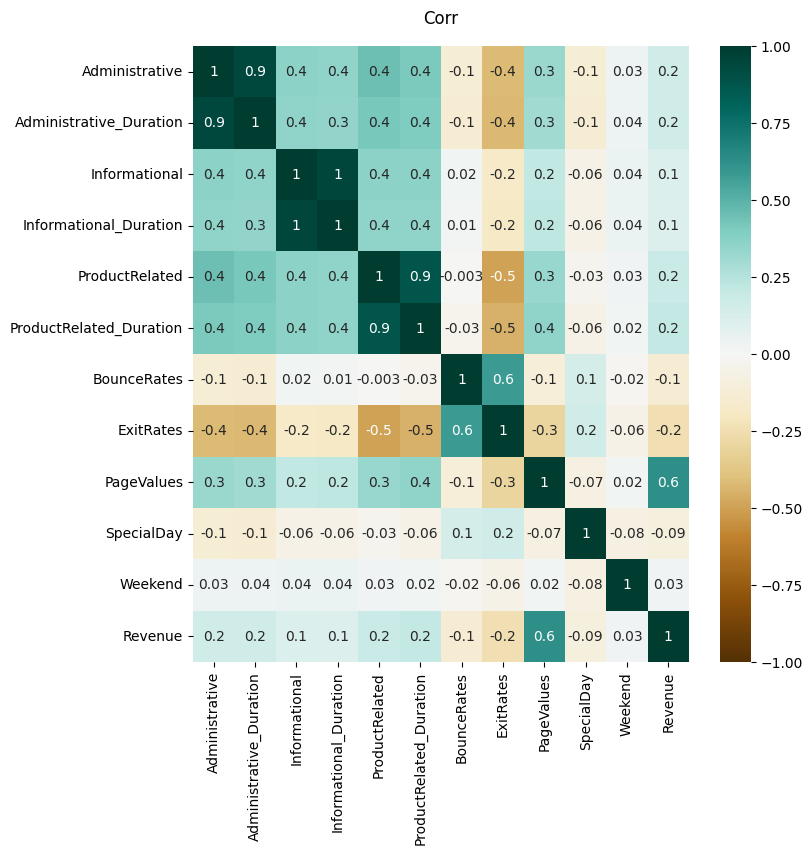

In [7]:
import seaborn as sns
plt.figure(figsize=(8, 8))
corr = dat.dropna().corr(method='spearman')
heatmap = sns.heatmap(corr,vmin=-1, vmax=1, annot=True, fmt='.1g', cmap='BrBG')
heatmap.set_title('Corr', fontdict={'fontsize':12}, pad=16);
plt.show()

In [8]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
print(upper_tri)

to_drop=[v for v in upper_tri.columns if any(upper_tri[v]>0.8)]
to_drop

                         Administrative  Administrative_Duration  \
Administrative                      NaN                  0.93848   
Administrative_Duration             NaN                      NaN   
Informational                       NaN                      NaN   
Informational_Duration              NaN                      NaN   
ProductRelated                      NaN                      NaN   
ProductRelated_Duration             NaN                      NaN   
BounceRates                         NaN                      NaN   
ExitRates                           NaN                      NaN   
PageValues                          NaN                      NaN   
SpecialDay                          NaN                      NaN   
Weekend                             NaN                      NaN   
Revenue                             NaN                      NaN   

                         Informational  Informational_Duration  \
Administrative                0.365072           

['Administrative_Duration',
 'Informational_Duration',
 'ProductRelated_Duration']

Will be dropping features 'Administrative_Duration' & 'Informational_Duration' owing to high degree of correlation
By virtue of how these metrics are calculated - bounce rates and exit rates would be highly correlated as bounce rate caters to visitors who left the site post that 1 page visit only while exit rates could indicate problems with downstream user funnel journey.
However, since the correlation coefficient was 0.58, the following analysis was done including both vars.

In [9]:
dat.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12129.000000,12129.000000,12129.000000,12129.000000,12129.000000,12129.000000,12129.000000,12129.000000,12129.000000,12129.000000
mean,2.353533,82.157925,0.511914,35.043669,32.239756,1214.545378,0.019245,0.040472,5.986854,0.062215
std,3.335689,177.929019,1.278969,141.840277,44.665453,1923.219818,0.043098,0.044563,18.706061,0.200060
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,198.700000,0.000000,0.014086,0.000000,0.000000
50%,1.000000,10.000000,0.000000,0.000000,18.000000,616.500000,0.002778,0.025000,0.000000,0.000000
75%,4.000000,95.500000,0.000000,0.000000,38.000000,1484.000000,0.015819,0.047500,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


Though 86% of customers are returning customers, the mean conversion was higher among 'new visitors' with mean conversion rates being higher on weekends vs weekdays

In [10]:
dat.groupby('Weekend')['Revenue'].mean()
dat.groupby('VisitorType')['Revenue'].mean()

VisitorType
New_Visitor          0.249409
Other                0.200000
Returning_Visitor    0.141933
Name: Revenue, dtype: float64

In [11]:
dat.groupby('Month')['Revenue'].mean()


Month
Aug     0.175520
Dec     0.127660
Feb     0.016760
Jul     0.152778
June    0.102473
Mar     0.104518
May     0.110372
Nov     0.255978
Oct     0.209472
Sep     0.191964
Name: Revenue, dtype: float64

In [12]:
dat.groupby('SpecialDay')['Revenue'].mean()

SpecialDay
0.0    0.168260
0.2    0.078652
0.4    0.053498
0.6    0.083095
0.8    0.034056
1.0    0.064935
Name: Revenue, dtype: float64

As shown in graph below, about two-thirds of data from May, November & March months only, while months January & April are not represented in the dataset at all.
Biased, non-representative sample

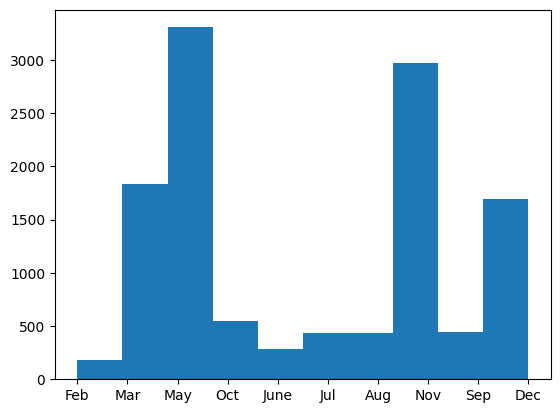

In [13]:
plt.hist(dat['Month'])
plt.show()

Splitting the data into train and test datasets

In [14]:
#Train/test split
#months of June—December as training set, and those corresponding to February—March as test set.
X_train = dat[dat.Month.isin(['June','Jul','Aug','Sep','Oct','Nov','Dec'])]
X_test = dat[dat.Month.isin(["Feb","Mar"])]

y_train = X_train.pop('Revenue')
y_test = X_test.pop('Revenue')

print('len of Train\n',len(X_train),
      'len of test',len(X_test))


len of Train
 6806 len of test 2016


Lets bin the infrequent categories into 'other' bucket - in our case condensing into category '99'

In [15]:
X_train.OperatingSystems.value_counts()

v = X_train.OperatingSystems.value_counts() <100
#X_train.OperatingSystems = X_train.OperatingSystems.cat.add_categories('others')
X_train.loc[X_train.OperatingSystems.isin(v.index[v]), 'OperatingSystems'] = '99'
X_train.OperatingSystems.value_counts()

2     3524
1     1501
3     1420
4      271
99      90
Name: OperatingSystems, dtype: Int64

In [16]:
#X_train.Browser.value_counts()

v = X_train.Browser.value_counts() <100
#X_train.Browser = X_train.Browser.cat.add_categories('others')
X_train.loc[X_train.Browser.isin(v.index[v]), 'Browser'] = '99'
X_train.Browser.value_counts()

2     4429
1     1400
99     396
4      347
5      234
Name: Browser, dtype: Int64

Repeat the same (binning of data) for test data

In [ ]:
#Repeat operation for X_test
X_test.OperatingSystems.value_counts()

v = X_test.OperatingSystems.value_counts() <100
#X_test.OperatingSystems = X_test.OperatingSystems.cat.add_categories('others')
X_test.loc[X_test.OperatingSystems.isin(v.index[v]), 'OperatingSystems'] = '99'
X_test.OperatingSystems.value_counts()

In [18]:
#Repeat operation for X_test
X_test.Browser.value_counts()

v = X_test.Browser.value_counts() <100
#X_test.OperatingSystems = X_test.OperatingSystems.cat.add_categories('others')
X_test.loc[X_test.Browser.isin(v.index[v]), 'Browser'] = '99'
X_test.Browser.value_counts()

2     1255
1      414
99     190
4      157
Name: Browser, dtype: Int64

Lets build our first classifier using a pipeline.
One hot encoding for categorical vars and scaling our numeric variables
Note: for following analysis we eliminated variables that are highly correlated from the classifier

In [20]:
#Fit a logistic regression
#step1: lets build pipeline
#since our dependent var is imbalanced runnign smote

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


numeric_features = ['Administrative','Informational','ProductRelated','PageValues','SpecialDay','BounceRates','ExitRates']
numeric_transformer = Pipeline(steps=[
    ("scaler",MinMaxScaler())
])
categorical_features = ['VisitorType', 'TrafficType', 'Region', 'Browser', 'OperatingSystems', 'Month']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [21]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LogisticRegression(max_iter=3000,class_weight='balanced'))]
)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Administrative',
                                                   'Informational',
                                                   'ProductRelated',
                                                   'PageValues', 'SpecialDay',
                                                   'BounceRates',
                                                   'ExitRates']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VisitorType', 'TrafficType',
                                                   'Region', 'Browser',
                                                   'OperatingSystems',
                                                   'Month'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=3000))])

In [22]:
lr_pred = model.predict(X_test)
print("model score: %.3f" % model.score(X_test, y_test))
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_pred, target_names=['0', '1']))

model score: 0.917
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1821
           1       0.55      0.78      0.65       195

    accuracy                           0.92      2016
   macro avg       0.76      0.86      0.80      2016
weighted avg       0.93      0.92      0.92      2016



#Interpretation of results
The overall model accuracy is 92%-and the model has good precision for class 0 (98%), that is of all the records classified as -non-purchasers, they indeed did not generate revenue and 93% recall - of all the records that did not generate revenue, 93% were accurately captured. The model however does not do quite so well for the under-represented class 1, with a precision of 55% and recall of 78% -  missing signal on what qualifies to be a purchaser.

#Second classifier -random forest classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=100,class_weight='balanced')
numeric_features = ['Administrative','Informational','ProductRelated','PageValues','SpecialDay','BounceRates','ExitRates']
numeric_transformer = Pipeline(steps=[
    ("scaler",MinMaxScaler())
])
preprocessor2 = ColumnTransformer(
    transformers=[
         ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)
Param = {}
model2 = Pipeline(
    steps=[("preprocessor", preprocessor2), ("model", rfc)]
)

model2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Administrative',
                                                   'Informational',
                                                   'ProductRelated',
                                                   'PageValues', 'SpecialDay',
                                                   'BounceRates',
                                                   'ExitRates']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VisitorType', 'TrafficType',
                                                   'Region', 'Browser',
                                                   'OperatingSystems',
                                                   'Month'])])),
                ('model', RandomForestClassifier(class_weight='balanced'))])

In [24]:
rfc_pred = model2.predict(X_test)
print("Random forest classifier score: %.3f" % model2.score(X_test, y_test))
print(classification_report(y_test, rfc_pred, target_names=['0', '1']))


Random forest classifier score: 0.944
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1821
           1       0.79      0.57      0.66       195

    accuracy                           0.94      2016
   macro avg       0.87      0.78      0.82      2016
weighted avg       0.94      0.94      0.94      2016



Improved accuracy from our logistic regression model with better precision but poorer recall for class 1 compared to logistic regression model. From business perspective, based on the use case we need to determine if precision or recall is our most important metric. Precision speaks to the fraction of relevant instances among the retrieved instances while recall is the fraction of relevant instances that were identified. Essentially meaning is identifying our revenue generating customers to a greater precision the most important metric, so custom offers/ pages can be sent their way or do we focus on improving the percentage of total relevant results (recall) correctly classified so lets say an expensive credit card offer would not be defaulted on. Personally, precision seems to be the way to go given the data we have so far for this use case with random forst classifier having marginaly better F1 score.

In [25]:
#how many counts of true vs false were returned by logistic regression model
np.unique(lr_pred, return_counts=True)

(array([False,  True]), array([1740,  276]))

In [26]:
#how many counts of true vs false were returned by random forest classifier
np.unique(rfc_pred, return_counts=True)

(array([False,  True]), array([1876,  140]))

In [27]:
y_test.value_counts()


False    1821
True      195
Name: Revenue, dtype: int64

#Third classifier -random forest classifier with grid search
In this iteration, we use grid search to find the optimum hyperparameters for our random forest classifier.

In [28]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "model__n_estimators": [100, 500, 1000],
    "model__max_depth": [1, 5, 10, 25],
    "model__max_features": [*np.arange(0.1, 1.1, 0.1)],
}
model3 = Pipeline(
    steps=[("preprocessor", preprocessor2), ("model", rfc)]
)
# Perform grid search, fit it, and print score
gs = GridSearchCV(model3, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1000)
grid_results = gs.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 2/5; 2/120] START model__max_depth=1, model__max_features=0.1, model__n_estimators=500
[CV 2/5; 2/120] END model__max_depth=1, model__max_features=0.1, model__n_estimators=500;, score=0.704 total time=   1.5s
[CV 5/5; 3/120] START model__max_depth=1, model__max_features=0.1, model__n_estimators=1000
[CV 5/5; 3/120] END model__max_depth=1, model__max_features=0.1, model__n_estimators=1000;, score=0.788 total time=   3.0s
[CV 5/5; 6/120] START model__max_depth=1, model__max_features=0.2, model__n_estimators=1000
[CV 5/5; 6/120] END model__max_depth=1, model__max_features=0.2, model__n_estimators=1000;, score=0.846 total time=   3.3s
[CV 1/5; 10/120] START model__max_depth=1, model__max_features=0.4, model__n_estimators=100
[CV 1/5; 10/120] END model__max_depth=1, model__max_features=0.4, model__n_estimators=100;, score=0.823 total time=   0.4s
[CV 2/5; 10/120] START model__max_depth=1, model__max_features=0.4, model__n_es

In [29]:
# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
#results_df

Best: [0.71613718 0.77226827 0.78298791 0.82574271 0.83162322 0.83999769
 0.84176013 0.84161296 0.84175981 0.84176002 0.84161318 0.84146634
 0.84146634 0.84146634 0.84146634 0.84131938 0.84146634 0.84146634
 0.84146634 0.84146634 0.84146634 0.84146634 0.84146634 0.84131938
 0.84146634 0.84146634 0.84146634 0.84131938 0.84146634 0.84146634
 0.81663414 0.82295097 0.82251012 0.83808496 0.83793833 0.83705695
 0.83588102 0.83793822 0.83837897 0.83779106 0.83676251 0.83705641
 0.83397012 0.83470509 0.83543974 0.83176629 0.83132511 0.83161912
 0.83044255 0.8301494  0.83044309 0.82941465 0.83132436 0.82941432
 0.82867968 0.82956095 0.83029538 0.82735669 0.82897304 0.82794471
 0.84587044 0.84234448 0.84440147 0.84910335 0.84866218 0.84851533
 0.85160098 0.85101285 0.85086687 0.85277658 0.8530707  0.85292375
 0.8527768  0.85321765 0.85395197 0.85277734 0.85307048 0.85292364
 0.85424609 0.8529245  0.85439293 0.85160141 0.85321754 0.85365861
 0.85027885 0.85321808 0.85130783 0.85013201 0.85086741 

In [30]:
best_clf = grid_results.best_estimator_
gs_pred = best_clf.predict(X_test)
print(classification_report(y_test, gs_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1821
           1       0.79      0.62      0.69       195

    accuracy                           0.95      2016
   macro avg       0.87      0.80      0.83      2016
weighted avg       0.94      0.95      0.94      2016



#What are my most important features?


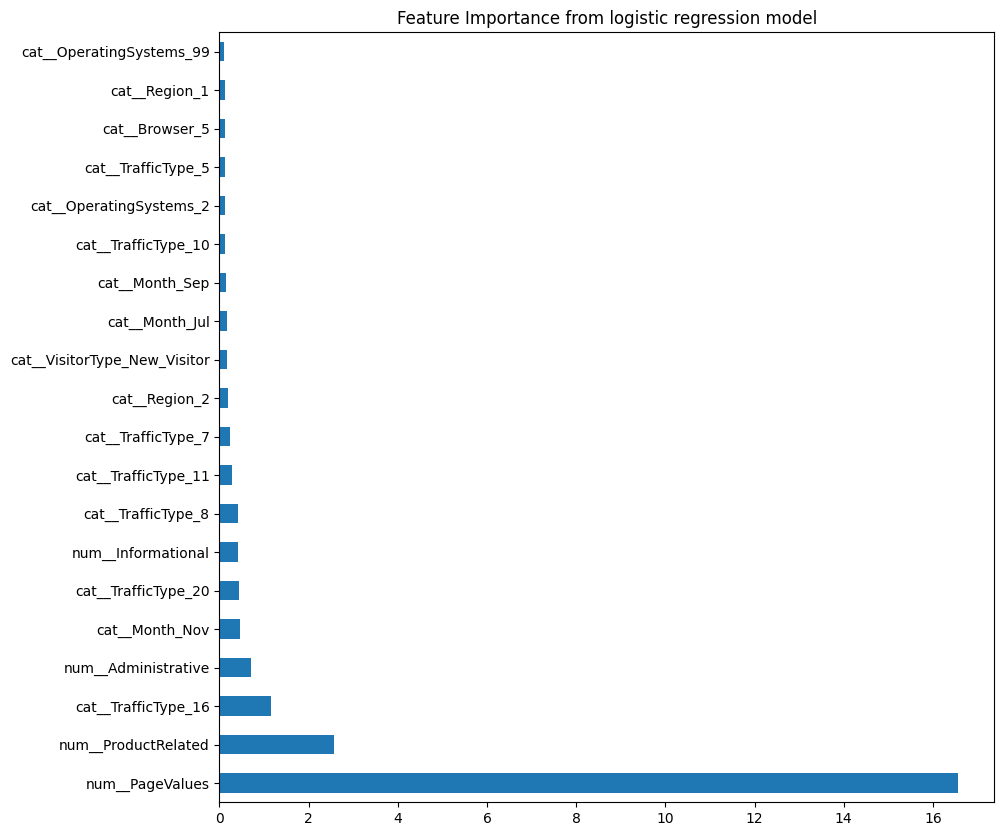

In [31]:
plt.figure(figsize=(10,10))

importance = model.named_steps['model'].coef_
feat_importances = pd.Series([i for sublist in importance for i in sublist], index=model[:-1].get_feature_names_out())
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance from logistic regression model')
plt.show()

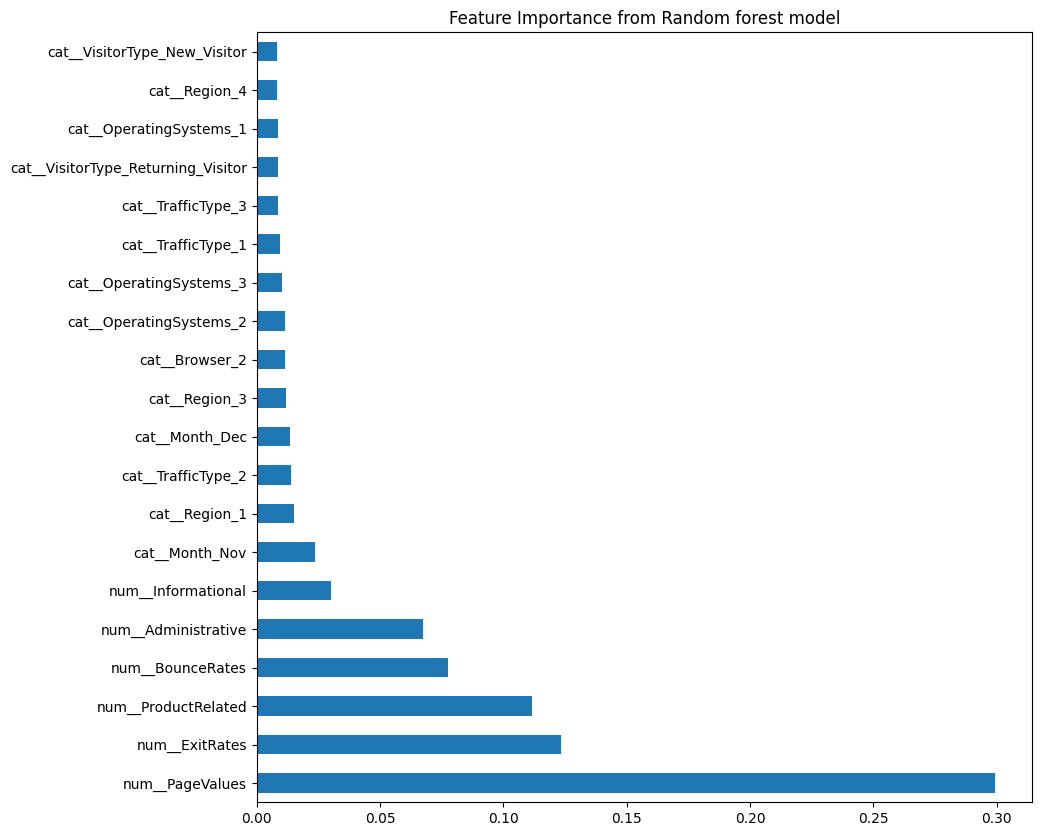

In [32]:
plt.figure(figsize=(10,10))

importance = model3.steps[1][1].feature_importances_
feat_importances = pd.Series(importance, index=model3[:-1].get_feature_names_out())
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance from Random forest model')
plt.show()

According to the more robust Random forest model's feature importance plot, PageValues, exit rates & productRelated are the top 3 most important predictors (2 of which concur with the logistic regression model as well).

#Task 2. Customer Segmentation
Generate user-behavior clusters based on the purchasing behavior data for the complete dataset.
Before proceeding with clustering, lets reduce the number of dimensions using Factorial Analysis of Mixed Data (FAMD)
But this needs the number of clusters to be defined, so running elbow curve using kmeans- so convert categorical to get dummy variables

In [33]:
from sklearn.cluster import KMeans

def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        kmeanModel = KMeans(n_clusters=k, random_state=10).fit(X)
        inertias.append(kmeanModel.inertia_)
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')
    plt.show()

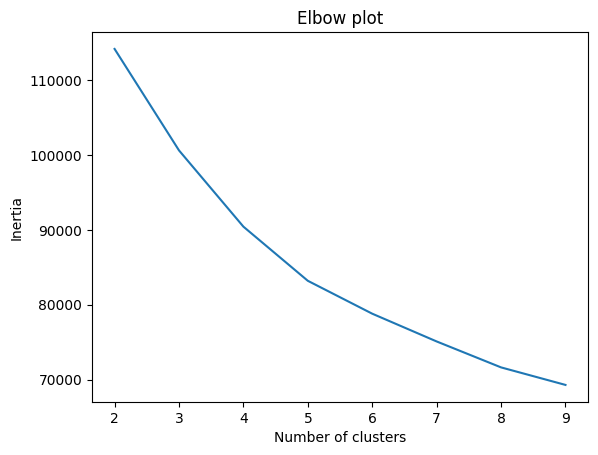

For n_clusters = 2 The average silhouette_score is : 0.3400361185602592


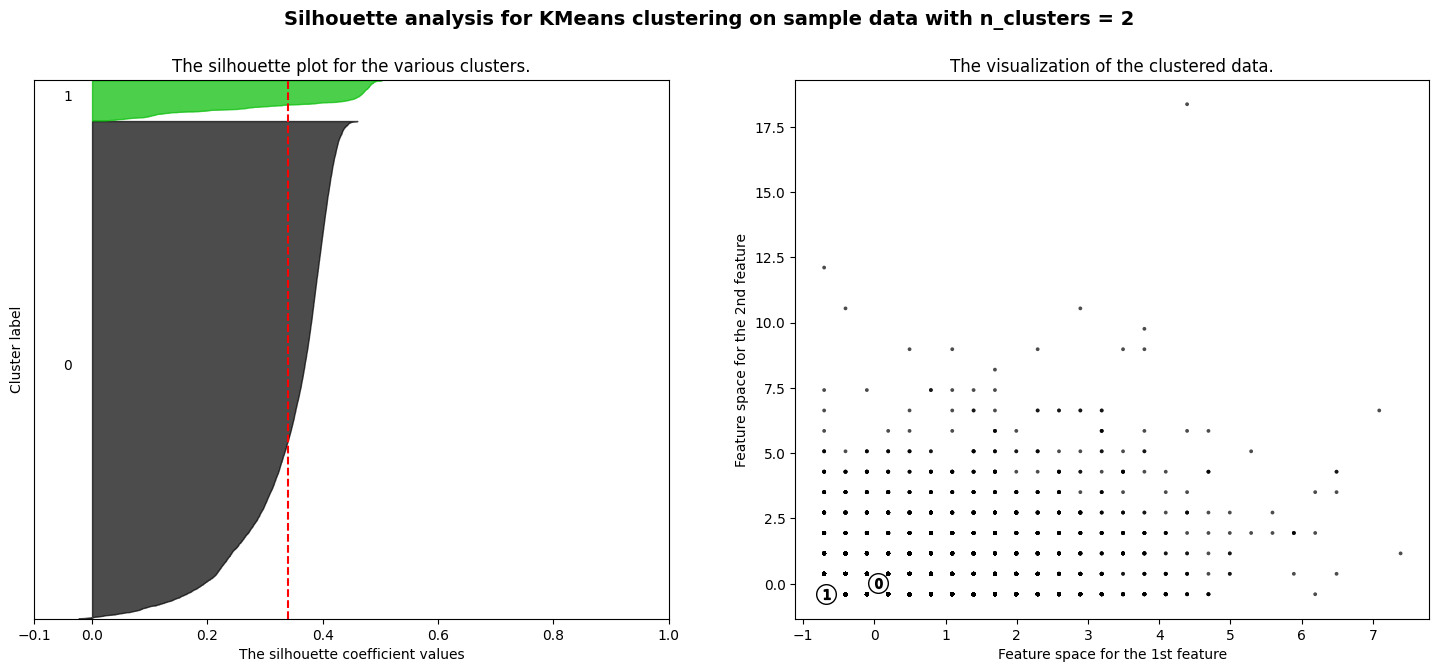

For n_clusters = 3 The average silhouette_score is : 0.2472912865643585


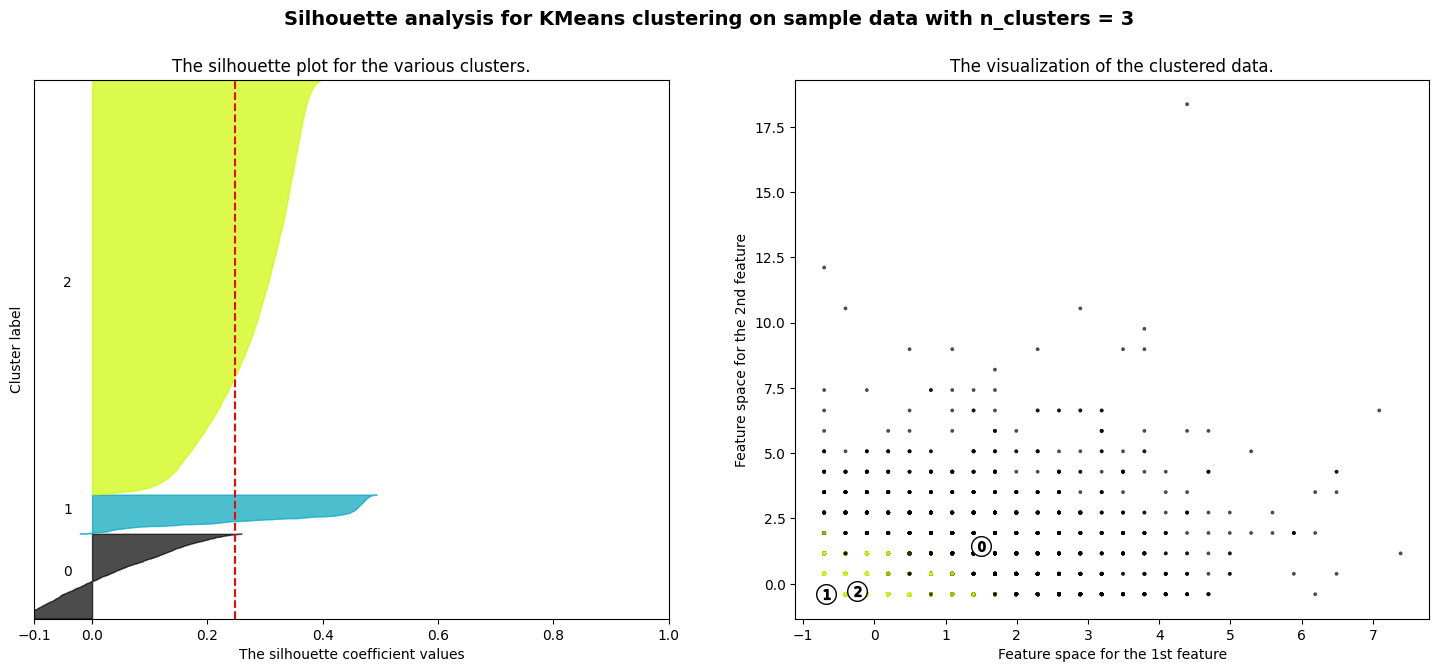

For n_clusters = 4 The average silhouette_score is : 0.2508613314785452


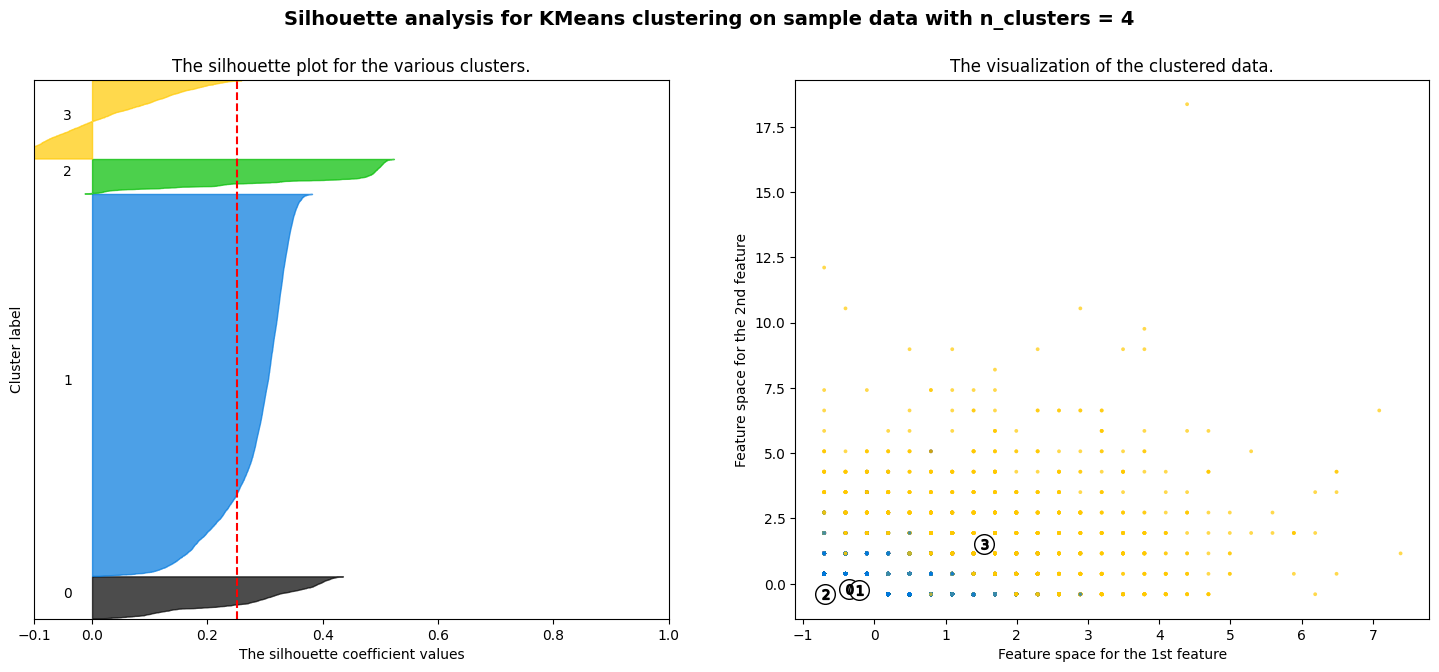

For n_clusters = 5 The average silhouette_score is : 0.25539630089188103


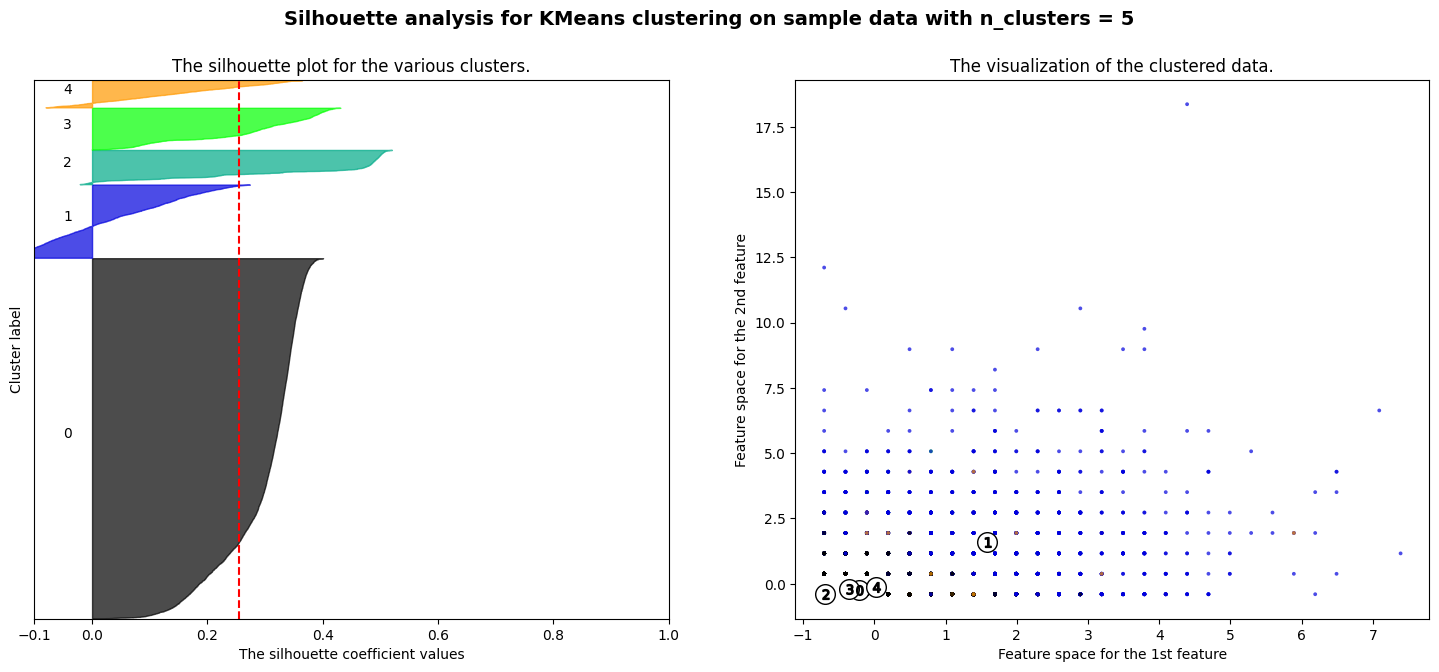

For n_clusters = 6 The average silhouette_score is : 0.164917615181424


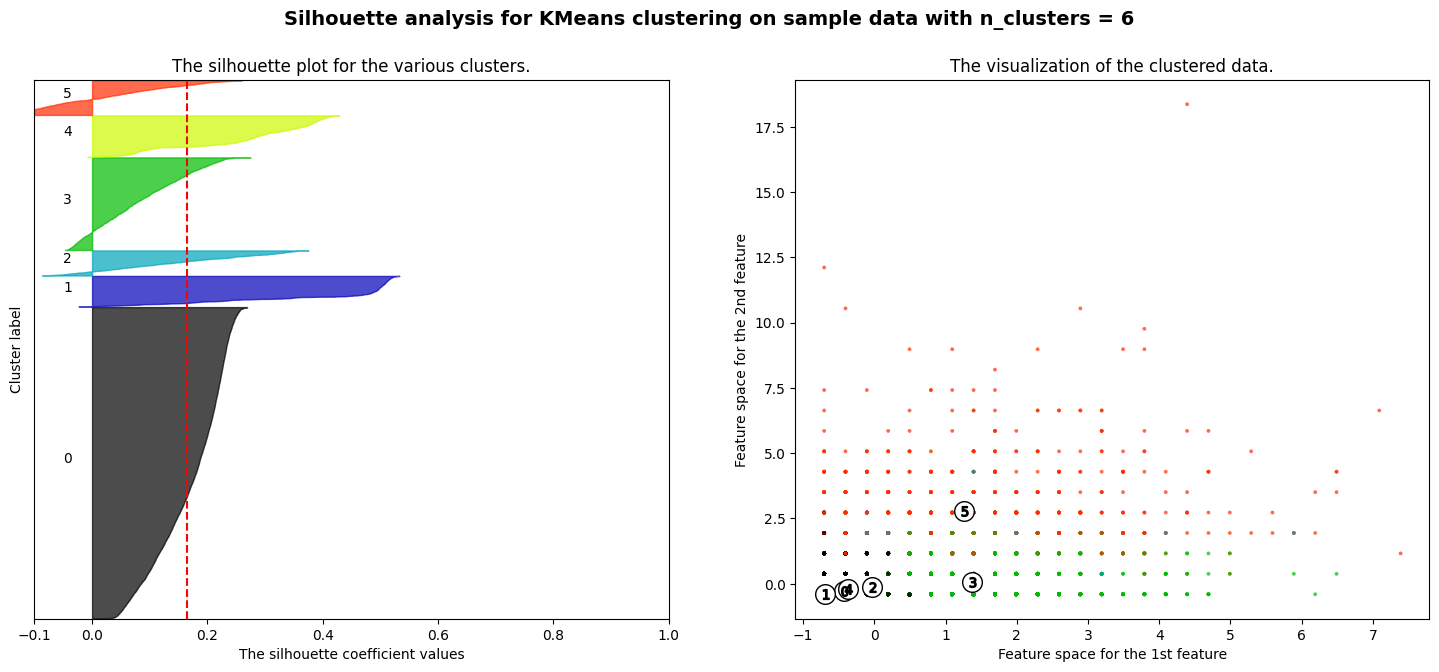

For n_clusters = 7 The average silhouette_score is : 0.13419906059119735


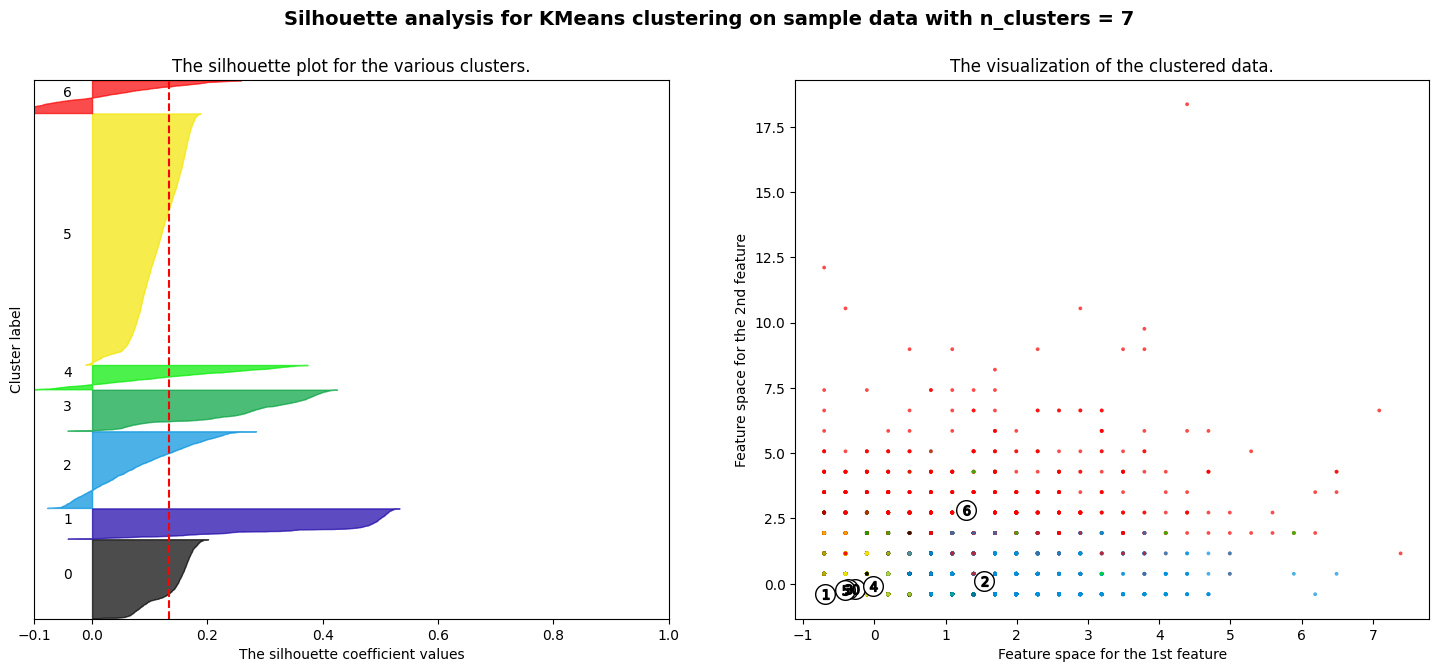

For n_clusters = 8 The average silhouette_score is : 0.13927871646068987


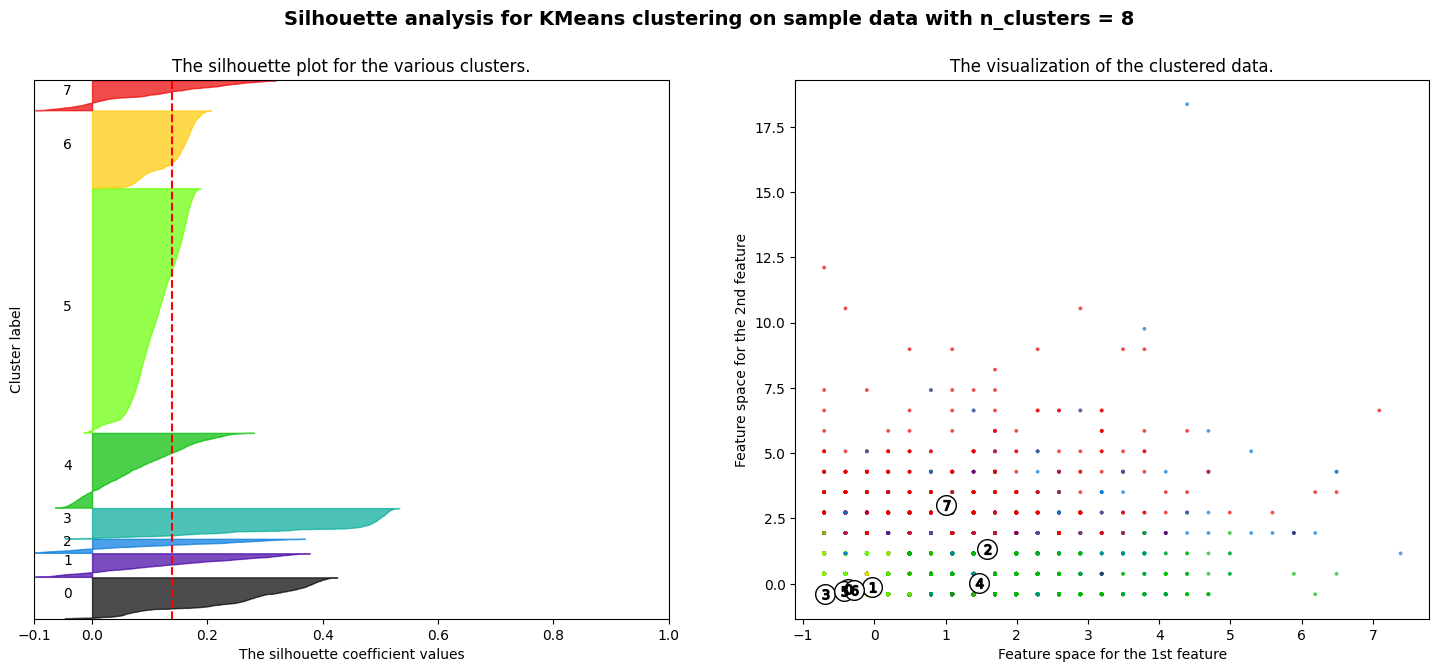

In [34]:
X = dat.copy()
from sklearn.preprocessing import StandardScaler
#numeric_features = ['Administrative', 'Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','PageValues']
X[numeric_features] = StandardScaler().fit_transform(X[numeric_features])

categoric_features = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']

#tweak the low volume counts into other
v = X.Browser.value_counts() <100
X.Browser = X.Browser.astype('category')
X.Browser = X.Browser.cat.add_categories('99')
X.loc[X.Browser.isin(v.index[v]), 'Browser'] = '99'
X.Browser.value_counts()

v = X.OperatingSystems.value_counts() <100
X.OperatingSystems = X.OperatingSystems.astype('category')
X.OperatingSystems = X.OperatingSystems.cat.add_categories('99')
X.loc[X.OperatingSystems.isin(v.index[v]), 'OperatingSystems'] = '99'
X.OperatingSystems.value_counts()

v = X.TrafficType.value_counts() <300
X.TrafficType = X.TrafficType.cat.add_categories('99')
X.loc[X.TrafficType.isin(v.index[v]), 'TrafficType'] = '99'
X.OperatingSystems.value_counts()

X_cat = pd.get_dummies(X[categoric_features])

# Merge DataFrames
processed_df = pd.concat([X[numeric_features], X_cat], axis=1)

ks = range(2,10)
visualize_elbow(processed_df,ks)

from utils2 import visualize_silhouette
visualize_silhouette(8, processed_df, random_state=10)

The above plot shows anywhere between 7-9 as ideal number of clusters while silhouette score indicates no reasonably strong cluster structures have been identified -silhouette scores <0.34

In [35]:
X_new= pd.concat([dat[numeric_features], X[categoric_features]], axis=1)
y = dat.Revenue

import prince

X_new[numeric_features] = StandardScaler().fit_transform(X_new[numeric_features])
#converting categorical featres to 'object'
for x in X_new.select_dtypes( exclude='float').columns:
    X_new[x] = X_new[x].astype('object')

/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12,

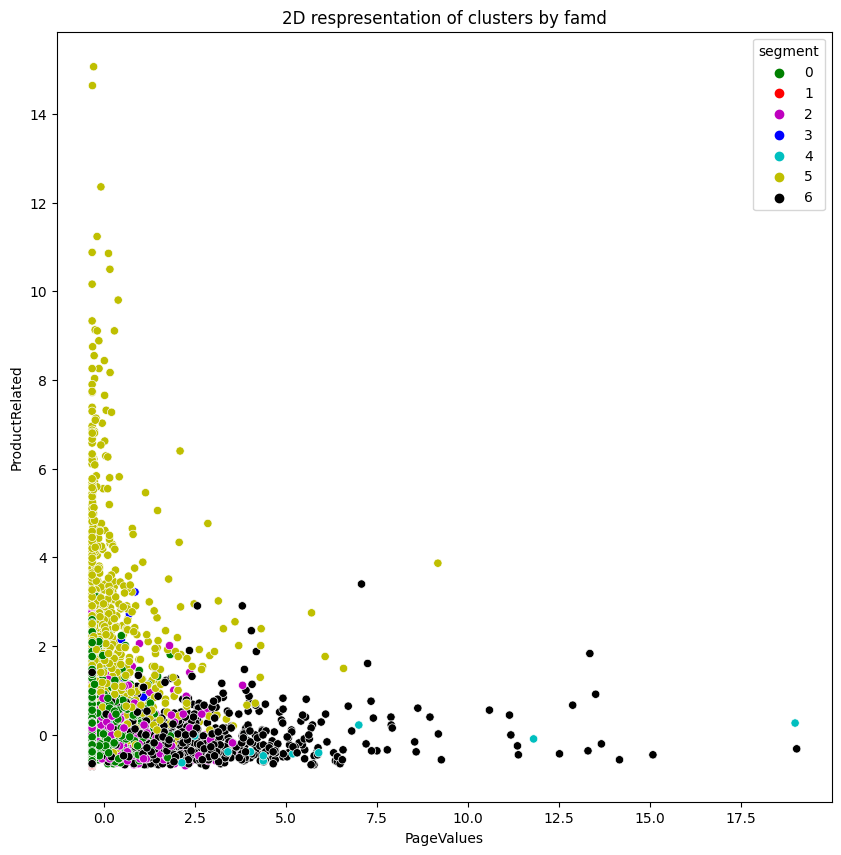

In [36]:
from sklearn.cluster import KMeans

famd = prince.FAMD(n_components=7, n_iter=5, copy=True, check_input=True, engine='auto',random_state=42)
famd = famd.fit(X_new)
coords = famd.row_coordinates(X_new)
kmodel = KMeans(n_clusters=7, random_state=42).fit(coords)
#X['segment'] = kmodel.labels_
X_new.loc[:, 'segment'] = kmodel.labels_

x_axis = X_new['PageValues']
y_axis= X_new['ProductRelated']
plt.figure(figsize=(10,10))
sns.scatterplot(x_axis, y_axis, hue=X_new['segment'], palette = ['g','r','m','b','c','y','k'])
plt.title('2D respresentation of clusters by famd')
plt.show()

/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


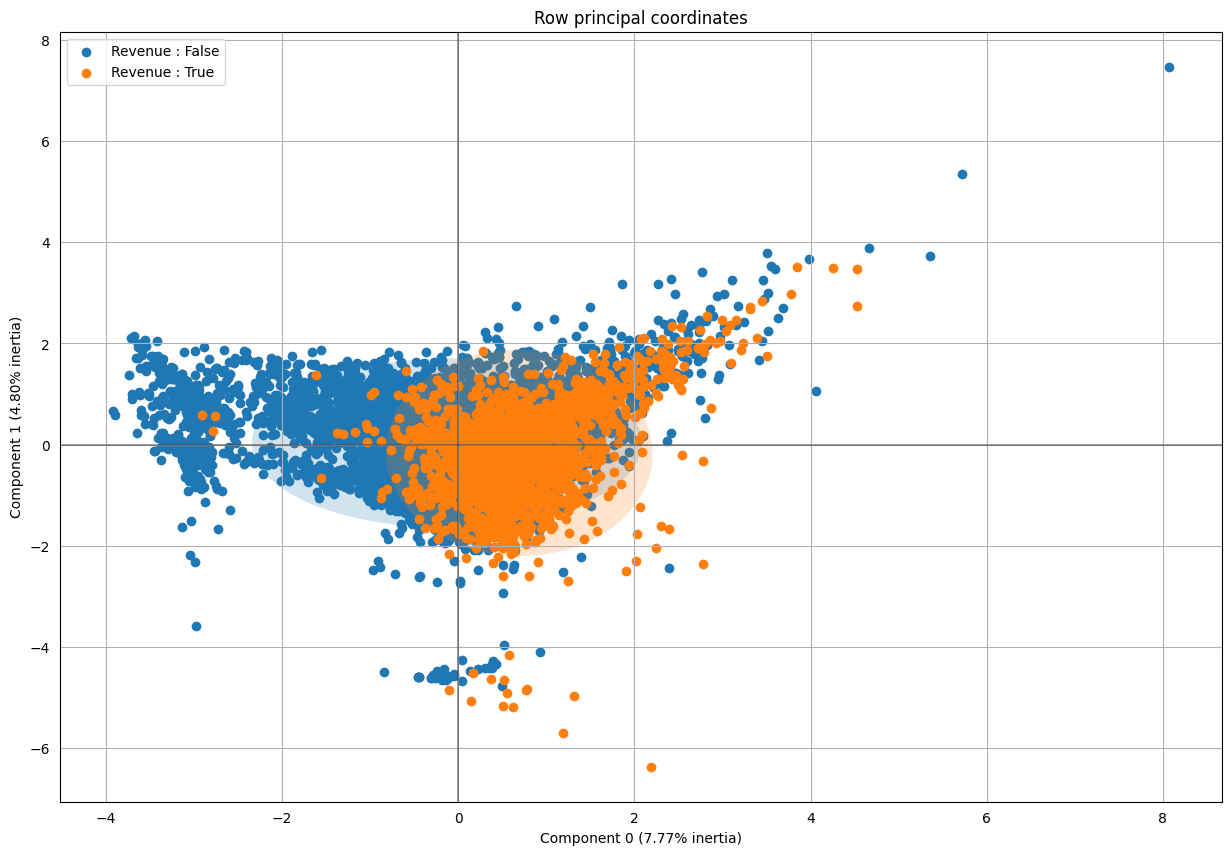

In [37]:
#plt.figure(figsize=(10,8))
famd.transform(X_new)
famd.plot_row_coordinates(X_new,figsize=(15, 10),color_labels=['Revenue : {}'.format(t) for t in dat['Revenue']] )
plt.show()

In [38]:
#size of each cluster

X_new.segment.value_counts()

0    5285
2    2118
6    1702
5    1270
3     977
1     720
4      57
Name: segment, dtype: int64

Clusters 3 & 5 are on the smaller side. Re-running with smaller number of clusters

/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12,

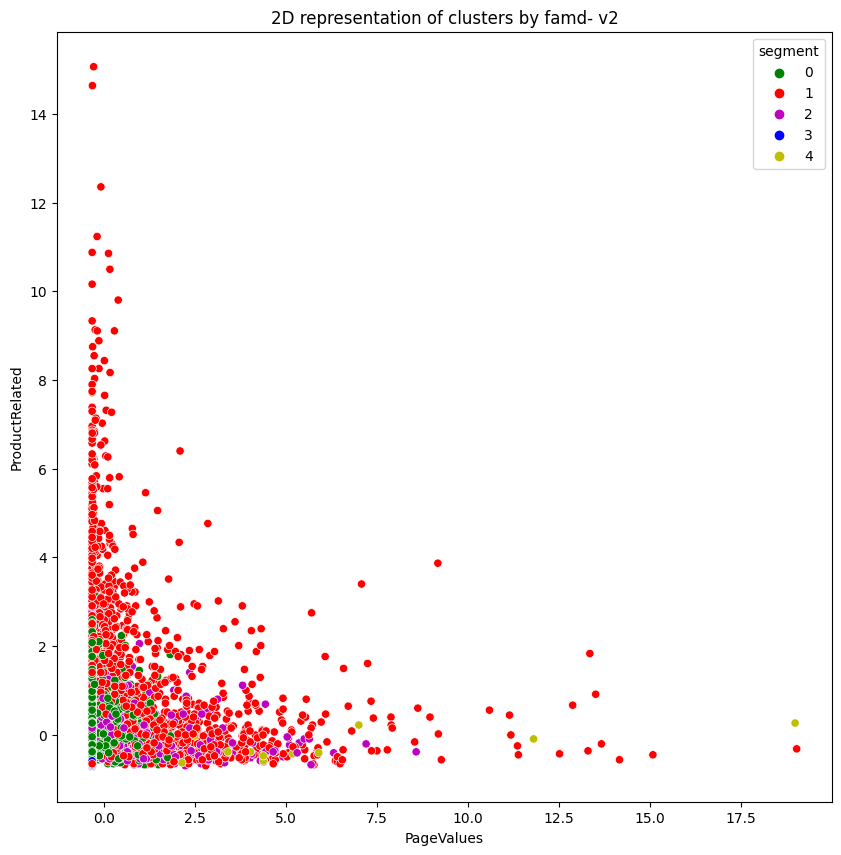

In [39]:
famd = prince.FAMD(n_components=5, n_iter=5, copy=True, check_input=True, engine='auto',random_state=42)
famd = famd.fit(X_new)
coords = famd.row_coordinates(X_new)
kmodel = KMeans(n_clusters=5, random_state=42).fit(coords)
#X['segment'] = kmodel.labels_
X_new.loc[:, 'segment'] = kmodel.labels_

x_axis = X_new['PageValues']
y_axis= X_new['ProductRelated']
plt.figure(figsize=(10,10))
sns.scatterplot(x_axis, y_axis, hue=X_new['segment'], palette = ['g','r','m','b','y'])
plt.title('2D representation of clusters by famd- v2')
plt.show()

In [41]:
X_new.segment.value_counts()

0    5108
3    3721
1    1976
2    1267
4      57
Name: segment, dtype: int64

In [42]:
#saving cluster characteristics to csv file to explore further
X_new.groupby('segment').describe().to_csv('stats2.csv', index=False)

Of the 5 clusters,
Cluster 1: 'Brief engagers': About 42% of data- this cohort is moderately engages with 'product related' webpages but have relatively lower pagevalue scores (the most important predictor for revenue) and check the webpages pretty close to special days, predominantly operating system 2, Browser 2 and are returning customers. Indicates efforts should be taken towards driving retention than new customer conversions as this cohort nearly makes up 42% data and do try to engage with website- [suggest tweaking the recommendation engine to surface more relevant pages].
Cluster 2: 'Unengaged': About 16% of data - least engaged with administrative, informative & product related webpages. High bounce and exit rates & check webpages fartherest away from special days- predominantly from uncommon browser types and traffic types (3&4). Again highlights the need to focus on retention vs customer acquisition. Suggest looking at page rendering for these uncommon browser types and study user flow to analyze where dropoff occurs.
Cluster 3: 'Page engagers':About 10% of data - engage in Administrative, Informational pages & Product related pages, but moderate Page Value scores, lowest bounce and exit rates, about half of this cohort shops during nov& Dec season with two-thirds from OS2 and 3/4'th of cohort from Browser 2.
Cluster 4: 'New customers': About 31% of data, similar Page Value scores as cluster 3 but not as engaged in webpages as the above cohort. Tend to engage closer to Special day and about half of the cohort consists of new visitors
Cluster 5: 'Other customers': smallest of lot (0.5% of data) with relatively higher values of PageValues (highest indicator of revenue generation) but relatively lower product related values with specialDay's min and max values being 0. They are the 'day off' special event shoppers, predominantly in the month of December, Operating System & Browser -'other' category with 85% of customers from 'other' category ( not new or returning customers).


saving summary stats of each cluster to study in greater details

In [ ]:
categoric_features = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']

#X.groupby(['segment','Month']).size().reset_index(name='count')
a = X_new.groupby(['segment'])["Month"].value_counts(normalize=True).mul(100).unstack("Month").fillna(0)
b = X_new.groupby(['segment'])["OperatingSystems"].value_counts(normalize=True).mul(100).unstack("OperatingSystems").fillna(0)
c = X_new.groupby(['segment'])["Browser"].value_counts(normalize=True).mul(100).unstack("Browser").fillna(0)
d = X_new.groupby(['segment'])["Region"].value_counts(normalize=True).mul(100).unstack("Region").fillna(0)
e = X_new.groupby(['segment'])["TrafficType"].value_counts(normalize=True).mul(100).unstack("TrafficType").fillna(0)
f = X_new.groupby(['segment'])["VisitorType"].value_counts(normalize=True).mul(100).unstack("VisitorType").fillna(0)
g = X_new.groupby(['segment'])["Weekend"].value_counts(normalize=True).mul(100).unstack("Weekend").fillna(0)

In [48]:
dfs =[a,b,c,d,e,f,g]
import functools as ft
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='segment'), dfs)
df_final.to_csv('categ.csv',index=False)

/var/folders/mt/52sww7c50ws851nqq95j74qc0000gp/T/ipykernel_53540/992300412.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'3_x', '4_x', '2_x', '1_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='segment'), dfs)


#Task 3. Semi-Supervised Learning
training data with the Revenue attribute for records from June—September only. For all records from October—December, however, Revenue attribute is missing

In [40]:
train = pd.read_csv('../dat/online_shoppers_intention.csv.gz', compression='gzip')

#lets delete the duplicate rows
train.drop_duplicates(keep=False, inplace=True)

#convert data to appropriate datatype
train['OperatingSystems']  =train['OperatingSystems'].astype('category',copy=False)
train['Browser']  =train['Browser'].astype('category',copy=False)
train['Region']  =train['Region'].astype('category',copy=False)
train['TrafficType']  =train['TrafficType'].astype('category',copy=False)
train['Revenue']  =train['Revenue'].astype('int',copy=False)

X_train2 = train[train.Month.isin(['June','Jul','Aug','Sep','Oct','Nov','Dec'])]
X_test2 = train[train.Month.isin(["Feb","Mar"])]

Lets test the base classifier accuracy by considering only records from Jun-Sep & measuring the classification performance on test data

In [41]:
X_train3 = train[train.Month.isin(['June','Jul','Aug','Sep'])]
y_train3 = X_train3.pop('Revenue')
y_test2 = X_test2.pop('Revenue')

In [42]:
clf = model.fit(X_train3, y_train3) # bringing in LR pipeline built above
preds = clf.predict(X_test2)
print(classification_report(y_test2, preds))

              precision    recall  f1-score   support

           0       0.98      0.79      0.87      1821
           1       0.30      0.84      0.44       195

    accuracy                           0.79      2016
   macro avg       0.64      0.82      0.66      2016
weighted avg       0.91      0.79      0.83      2016



With only 4 months of training data, the overall accuracy is 79% with precision for class 0 being 98% and precision for class 1 being 30%.

Now, lets set the revenue flag for the months of Oct - Dec to -1 (unknown) for semi-supervised objective

In [43]:
X_train2.loc[X_train2.Month.isin(['Oct','Nov','Dec']),'Revenue'] = -1
X_train2.Revenue.value_counts()

-1    5210
 0    1339
 1     257
Name: Revenue, dtype: int64

In [44]:
#lets check the data to ensure the mapping were accurate
X_train2.groupby(['Month','Revenue']).count()

Administrative  Administrative_Duration  Informational  \
Month Revenue                                                           
Aug    0                  357                      357            357   
       1                   76                       76             76   
Dec   -1                 1692                     1692           1692   
Jul    0                  366                      366            366   
       1                   66                       66             66   
June   0                  254                      254            254   
       1                   29                       29             29   
Nov   -1                 2969                     2969           2969   
Oct   -1                  549                      549            549   
Sep    0                  362                      362            362   
       1                   86                       86             86   

               Informational_Duration  ProductRelated  \
Month Revenue                                           
Aug    0                          357             357   
       1                           76              76   
Dec   -1                         1692            1692   
Jul    0                          366             366   
       1                           66              66   
June   0                          254             254   
       1                           29              29   
Nov   -1                         2969            2969   
Oct   -1                          549             549   
Sep    0                          362             362   
       1                           86              86   

               ProductRelated_Duration  BounceRates  ExitRates  PageValues  \
Month Revenue                                                                
Aug    0                           357          357        357         357   
       1                            76           76         76          76   
Dec   -1                          1692         1692       1692        1692   
Jul    0                           366          366        366         366   
       1                            66           66         66          66   
June   0                           254          254        254         254   
       1                            29           29         29          29   
Nov   -1                          2969         2969       2969        2969   
Oct   -1                           549          549        549         549   
Sep    0                           362          362        362         362   
       1                            86           86         86          86   

               SpecialDay  OperatingSystems  Browser  Region  TrafficType  \
Month Revenue                                                               
Aug    0              357               357      357     357          357   
       1               76                76       76      76           76   
Dec   -1             1692              1692     1692    1692         1692   
Jul    0              366               366      366     366          366   
       1               66                66       66      66           66   
June   0              254               254      254     254          254   
       1               29                29       29      29           29   
Nov   -1             2969              2969     2969    2969         2969   
Oct   -1              549               549      549     549          549   
Sep    0              362               362      362     362          362   
       1               86                86       86      86           86   

               VisitorType  Weekend  
Month Revenue                        
Aug    0               357      357  
       1                76       76  
Dec   -1              1692     1692  
Jul    0               366      366  
       1                66       66  
June   0               254      254  
  

#semi-supervised learning via label-propagation

In [45]:
y_unlab = X_train2.pop('Revenue')

v = X_train2.OperatingSystems.value_counts() <100
X_train2.OperatingSystems = X_train2.OperatingSystems.cat.add_categories(99)
X_train2.loc[X_train2.OperatingSystems.isin(v.index[v]), 'OperatingSystems'] = 99
X_train2.OperatingSystems.value_counts()

v = X_train2.Browser.value_counts() <100
X_train2.Browser = X_train2.Browser.cat.add_categories(99)
X_train2.loc[X_train2.Browser.isin(v.index[v]), 'Browser'] = 99
X_train2.Browser.value_counts()

v = X_train2.TrafficType.value_counts() <100
X_train2.TrafficType = X_train2.TrafficType.cat.add_categories(99)
X_train2.loc[X_train2.TrafficType.isin(v.index[v]), 'TrafficType'] = 99
X_train2.TrafficType.value_counts()

/var/folders/mt/52sww7c50ws851nqq95j74qc0000gp/T/ipykernel_2968/2277469818.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train2.OperatingSystems = X_train2.OperatingSystems.cat.add_categories(99)
/var/folders/mt/52sww7c50ws851nqq95j74qc0000gp/T/ipykernel_2968/2277469818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train2.Browser = X_train2.Browser.cat.add_categories(99)
/var/folders/mt/52sww7c50ws851nqq95j74qc0000gp/T/ipykernel_2968/2277469818.py:14: SettingWithCopyWarning: 
A value is tryi

2     2611
1     1323
3      881
13     391
4      341
10     318
8      257
20     178
5      169
6      155
11     146
99      36
12       0
9        0
14       0
15       0
16       0
17       0
18       0
19       0
7        0
Name: TrafficType, dtype: int64

In [47]:
from sklearn.semi_supervised import LabelPropagation

numeric_features = ['Administrative_Duration','Informational_Duration','ProductRelated_Duration','Administrative','Informational','ProductRelated','ProductRelated_Duration','PageValues','SpecialDay','BounceRates','ExitRates']
numeric_transformer = Pipeline(steps=[
    ("scaler",MinMaxScaler())
])
categorical_features = ['VisitorType', 'TrafficType', 'Region', 'Browser', 'OperatingSystems','Month']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
        ,("cat", categorical_transformer, categorical_features)
    ]
)


model4 = Pipeline(
    steps=[("preprocessor", preprocessor), ("lp", LabelPropagation(kernel='rbf', # {'knn', 'rbf'} default='rbf'
                                                                    gamma=70, # default=20, Parameter for rbf kernel.
                                                                    n_neighbors=20,
                                                                   n_jobs=-1))]
)


model4.fit(X_train2,y_unlab)


/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Administrative_Duration',
                                                   'Informational_Duration',
                                                   'ProductRelated_Duration',
                                                   'Administrative',
                                                   'Informational',
                                                   'ProductRelated',
                                                   'ProductRelated_Duration',
                                                   'PageValues', 'SpecialDay',
                                                   'BounceRates',
                                                   'ExitRates']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VisitorType', 'TrafficType',
                                                   'Region', 'Browser',
                                                   'OperatingSystems',
                                                   'Month'])])),
                ('lp', LabelPropagation(gamma=70, n_jobs=-1, n_neighbors=20))])

In [48]:
semi_sup_preds = model4.named_steps.lp.transduction_[-5210:]#5210 is numbe rof recs from Oct-Dec

In [49]:
check = train[train.Month.isin(['Oct','Nov','Dec'])]['Revenue']
check.sum() #1091 yes
semi_sup_preds.sum() #420 yes

424

Lets use self-labeled data and training data together to see if classification performance on test data improves

In [50]:
y_mixed = np.concatenate((y_train3, semi_sup_preds))

In [51]:
assert len(X_train2) == len(y_mixed)

In [52]:
clf = model.fit(X_train2, y_mixed)
preds = clf.predict(X_test2)
print(classification_report(y_test2, preds))

              precision    recall  f1-score   support

           0       0.96      0.62      0.75      1821
           1       0.17      0.74      0.28       195

    accuracy                           0.63      2016
   macro avg       0.57      0.68      0.52      2016
weighted avg       0.88      0.63      0.71      2016



The logistic regression model had a baseline accuracy of 79%. Our semi supervised modle accuracy dropped to 63%. The number of 'true' labels predicted were only 424 while the actual count of 'true' labels for this period is about 1021. We need a better fit for label propagation.

#v2
Lets label the data using label spreading vs label propagation

In [ ]:
from sklearn.semi_supervised import LabelSpreading

model5 = Pipeline(
    steps=[("preprocessor", preprocessor), ("ls", LabelSpreading(alpha=0.5, gamma=70,kernel='rbf', max_iter=100))]
)
model5.fit(X_train2,y_unlab)
semi_sup_preds2 = model5.named_steps.ls.transduction_#5210 is numbe rof recs from Oct-Dec
semi_sup_preds2.sum() #210, 518

In [58]:
#y_mixed2 = np.concatenate((y_train3, semi_sup_preds2))
clf = model5.fit(X_train2, semi_sup_preds2)
preds = clf.predict(X_test2)
print(classification_report(y_test2, preds))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1821
           1       0.10      0.09      0.10       195

    accuracy                           0.84      2016
   macro avg       0.50      0.50      0.50      2016
weighted avg       0.83      0.84      0.83      2016



Our model accuracy is now higher than our baseline model 84% vs 80%.

Lets do the re-training but now dropping the highly collinear vars from further analysis (refer list to_drop for columns dropped)

In [59]:
from sklearn.compose import ColumnTransformer

numeric_features = ['Administrative','Informational','ProductRelated','ProductRelated_Duration','PageValues','BounceRates','ExitRates']

numeric_transformer = Pipeline(steps=[
    ("scaler",MinMaxScaler())
])
categorical_features = ['VisitorType', 'TrafficType', 'Region', 'Browser', 'OperatingSystems','Month']
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')

cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
        ,("cat", cat_pipe, categorical_features)
    ]
)
#preprocessor = ColumnTransformer([('cat', cat_pipe, categorical_transformer)], remainder='passthrough')
model6 = Pipeline(
    steps=[("preprocessor", preprocessor), ("lp", LabelPropagation(kernel='rbf', # {'knn', 'rbf'} default='rbf'
                                                                    gamma=80, # default=20, Parameter for rbf kernel.
                                                                    n_neighbors=20,
                                                                   n_jobs=-1))]
)


model6.fit(X_train2,y_unlab)

/Users/sbezawada/.virtualenvs/midterm/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Administrative',
                                                   'Informational',
                                                   'ProductRelated',
                                                   'ProductRelated_Duration',
                                                   'PageValues', 'BounceRates',
                                                   'ExitRates']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['VisitorType', 'TrafficType',
                                                   'Region', 'Browser',
                                                   'OperatingSystems',
                                                   'Month'])])),
                ('lp', LabelPropagation(gamma=80, n_jobs=-1, n_neighbors=20))])

In [60]:
semi_sup_preds3 = model6.named_steps.lp.transduction_

In [61]:
check.sum() #1091 yes
semi_sup_preds3.sum() #617

617

In [62]:
clf = model6.fit(X_train2, semi_sup_preds3)
preds = clf.predict(X_test2)
print(classification_report(y_test2, preds))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1821
           1       0.09      0.05      0.06       195

    accuracy                           0.86      2016
   macro avg       0.50      0.50      0.49      2016
weighted avg       0.82      0.86      0.84      2016



Removing highly collinear vars helped with the graph analysis - attribute the correct label to missing data w/o ties driving accuracy higher from 84% to 86%.